## linear regression – the Bayesian way

> Davidson-Pilon, C. Bayesian Methods for Hackers: Probabilistic Programming and Bayesian Inference. (Addison-Wesley Professional, 2015).

> Salvatier J, Wiecki TV, Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 https://doi.org/10.7717/peerj-cs.55


To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters.

* Y: outcome, normal distributed priors for the parameters with 
  * $\mu$: expected value
  * $\sigma$: observation error

$$ Y  \sim \mathcal{N}(\mu, \sigma^2) $$

* $ \mu $: is a linear function of two predictor variables $X_1$ and $X_2$
* $ \alpha $: intercept
* $ \beta_1 $, $ \beta_2 $: coefficients for covariates $X_i$
$$ \mu = \alpha + \beta_1 X_1 + \beta_2 X_2 = X\beta + \epsilon $$

We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to weak information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$ \alpha \sim \mathcal{N}(0, 100) $$
$$ \beta_i \sim \mathcal{N}(0, 100) $$
$$ \sigma \sim \lvert\mathcal{N}(0, 1){\rvert} $$


## Generating random data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

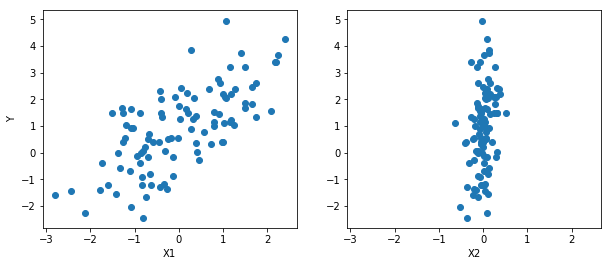

In [2]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');


## Model Specification

In [7]:
import pymc3 as pm

basic_model = pm.Model()
with basic_model:

    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [9]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  Parameters
 |  ----------
 |  mu : float
 |      Mean.
 |  sd : float
 |      Standard deviation (sd > 0).
 |  tau : float
 |      Precision (tau > 0).
 |  
 |  Method resolution order:
 |      Normal
 |      pymc3.distr

## Model fitting: maximum a posteriori methods (MAP)
* mode of the posterior distribution 
* generally found using numerical optimization methods
  * Broyden–Fletcher–Goldfarb–Shanno (BFGS) 
* often fast and easy
* only gives a point estimate
* biased if 
  * the mode isn’t representative of the distribution
  * high dimensions, high density, low probability
* only finds a local optimum 
* no estimate of uncertainty


In [11]:
map_estimate = pm.find_MAP(model=basic_model)

print(map_estimate)

Optimization terminated successfully.
         Current function value: 149.017982
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21
{'alpha': array(0.9065985497559482), 'beta': array([ 0.94848602,  2.60705514]), 'sigma_log_': array(-0.032781470174030686)}


In [22]:
import math
print(math.exp(-0.032781470174030686))

0.9677500187263003


In [28]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

print(map_estimate)
print(math.exp(-0.030009775203258385))

Optimization terminated successfully.
         Current function value: 149.019762
         Iterations: 4
         Function evaluations: 176
{'alpha': array(0.9090521898977764), 'beta': array([ 0.95140146,  2.61437458]), 'sigma_log_': array(-0.030009775203258385)}
0.9704360472925316


## Model fitting: sampling
> a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution.

* No-U-Turn Sampler (NUTS)
* inference algorithm called "auto-diff variational inference" (ADVI)

In [34]:
with basic_model:
    # obtain starting values via MAP
    start = pm.find_MAP(fmin = optimize.fmin_powell)
    
    # instantiate sample
    step = pm.NUTS(scaling = start)
    
    # draw 2000 posterior samples
    trace = pm.sample(2000, step, start = start)

Optimization terminated successfully.
         Current function value: 149.019762

100%|██████████| 2000/2000 [00:04<00:00, 402.91it/s]


         Iterations: 4
         Function evaluations: 176


## Posterior analysis
* plotting and summarization for inspecting the sampling output

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4b17efcc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb4b170ea58>]], dtype=object)

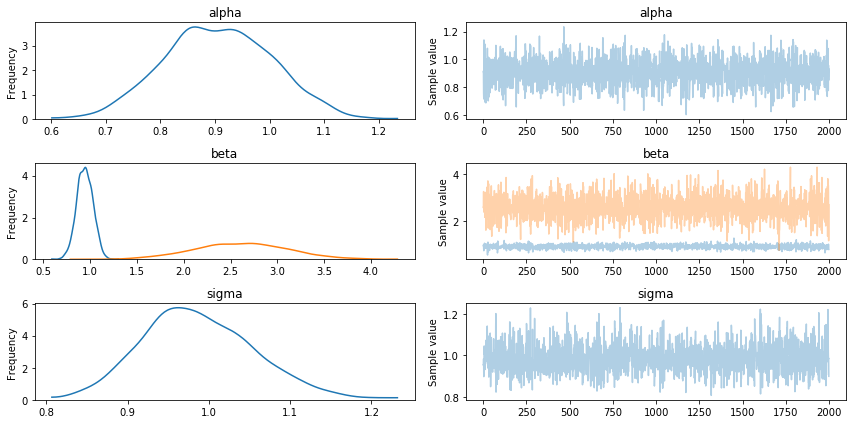

In [37]:
pm.traceplot(trace)

In [43]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.905            0.097            0.002            [0.717, 1.086]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.719          0.838          0.904          0.974          1.094


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.945            0.086            0.002            [0.777, 1.106]
  2.608            0.499            0.011            [1.638, 3.573]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.778          0.885          0.945          1.005          1.107
  1.638          2.276          2.610   